# HCN channels: $I_h$

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/HCN_channels" folder

In [2]:
data_folder = "data/HCN_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/HCN_channels


['data/HCN_channels/K_deact_1.abf',
 'data/HCN_channels/K_deact_3.abf',
 'data/HCN_channels/K_deact_2.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/HCN_channels/K_deact_1.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(11, 2, 28500)
sampling freq: 49999.99999999999 Hz


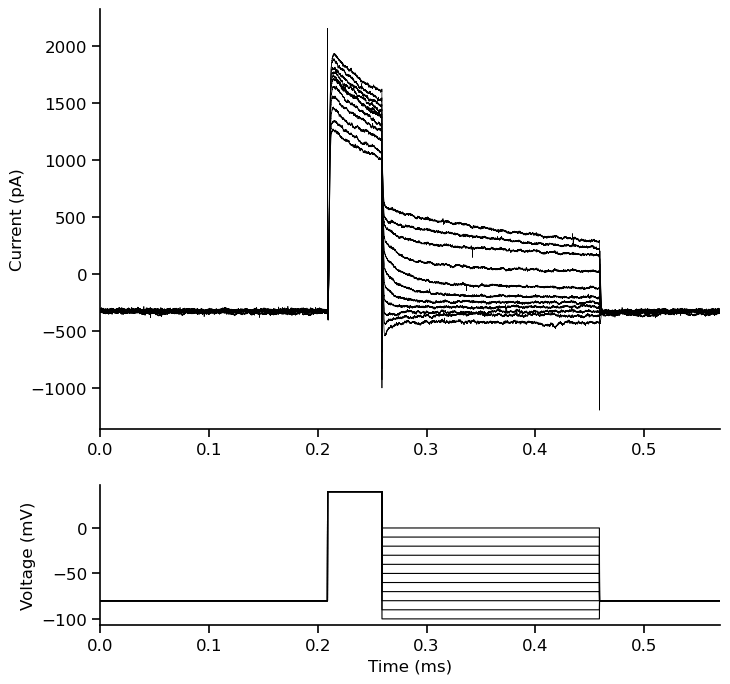

In [4]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Define the time window to measure tail currents

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

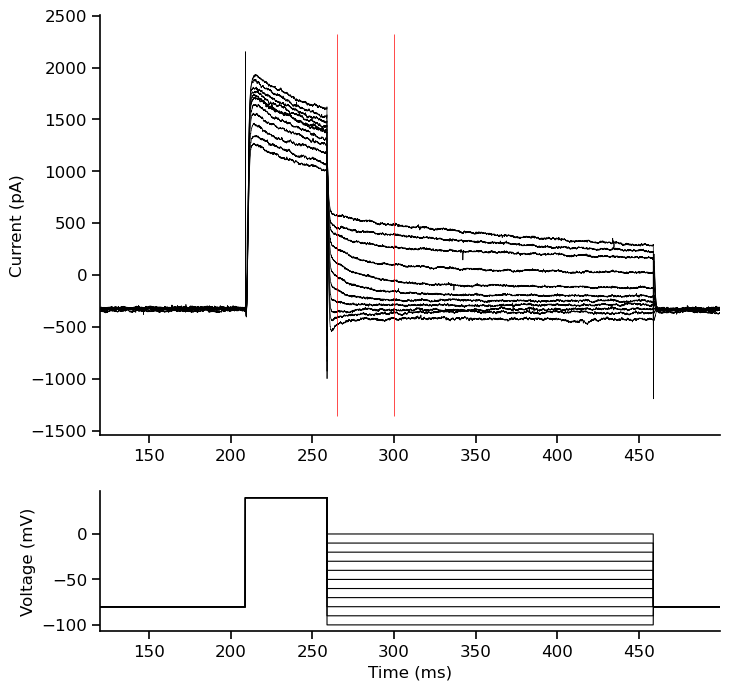

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 120  # milliseconds
end_time = 500   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 265  # milliseconds
marker_2 = 300    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 2.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [6]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = False

# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_baseline = 0 # milliseconds
end_baseline = 1 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'


# --------------------------------------------------------------------------------------------------------------------
if subtract_baseline:
    baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_baseline, end_baseline, sampling_freq, measurement_type)

    # Subtract baseline from the sweeps
    num_traces = sweeps.shape[0]
    for i in range(num_traces):
        sweeps[i,0] -= baseline_current[i]

    current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
    voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
    ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
    ax[0].set_title('After baseline subtraction')
    plt.show()

### 3.2. Measure the instantaneous currents (when channels are open)

Here we will be using the timepoints from the markers we defined above and get the peak currents in that time window.

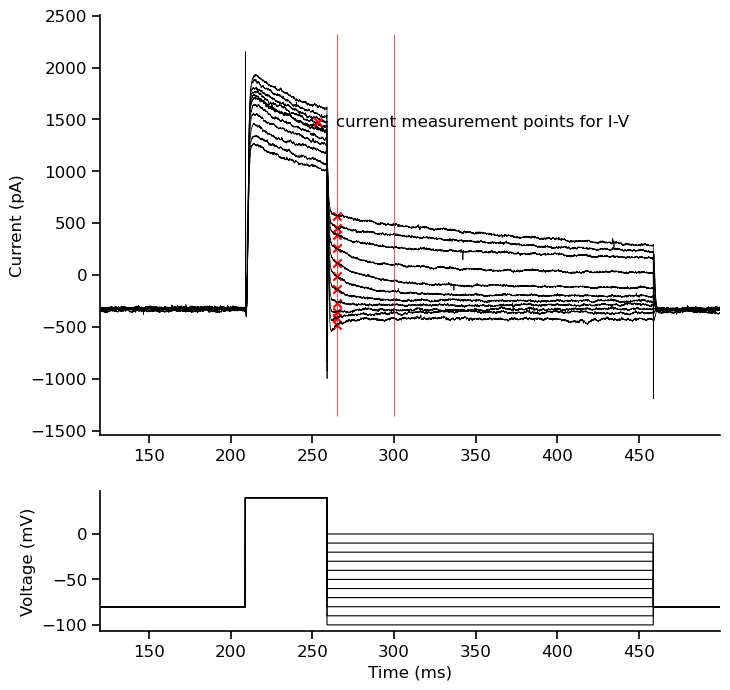

In [7]:
ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
marker_1_idx = time_to_index(marker_1, sampling_freq)
current_steps = current_at_marker1 = sweeps[:,0,marker_1_idx]
ax[0].scatter([marker_1]*len(current_steps), current_steps, color='red', marker='x', label="current measurement points for I-V")
ax[0].legend(loc='upper left', bbox_to_anchor=(0.3, 0.8))
plt.show()

### 2.3. To plot the IV, get the holding voltages from the first phase of the step protocol

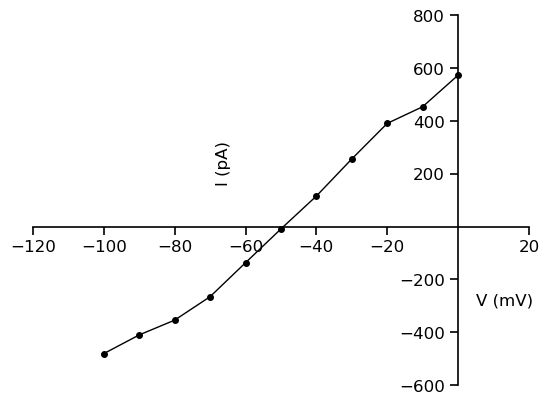

In [10]:
# Specify the timepoint where the voltage should be measured
voltage_timepoint = 300

# -----------------------------------------------------------------------------
channel = 1
voltage_steps = sweeps[:, channel, time_to_index(voltage_timepoint, sampling_freq)]
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))
plt.show()

### 2.3. Fit a line to the I-V points to estimate the reversal potential and conductance

G = slope = 12.271 nS
Resistance = 1/slope = 81.495 MOhm
Reversal potential: -49.549 mV


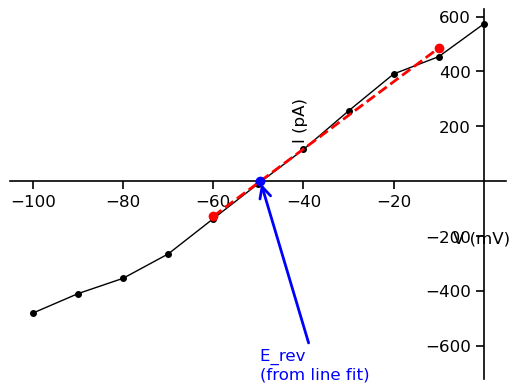

In [22]:
# Choose which range of point you want to fit a line to
# Here it is important to select a range of points in the "linear" (right) part of the IV curve, where the Na channels are open.
# (We will use this line to figure out the reversal potential)
voltage_start = -60
voltage_end = +0


# -----------------------------------------------------------------------------------------------------------------------
assert voltage_start < voltage_end, "voltage_start must be less than voltage_end"
assert voltage_start < np.max(voltage_steps), "voltage_start must be less than the largest voltage step"
assert voltage_end > np.min(voltage_steps), "voltage_end must be greater than the smallest voltage step"
assert voltage_end <= np.max(voltage_steps), "voltage_end must be less than the largest voltage step"
assert voltage_start >= np.min(voltage_steps), "voltage_start must be greater than the smallest voltage step"

# Convert voltage start/end to index
points_start = np.where(voltage_steps >= voltage_start)[0][0]
points_end = np.where(voltage_steps <= voltage_end)[0][-1]

# Fit a line to the points
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))
from scipy.stats import linregress
if points_end > len(voltage_steps):
    points_end = len(voltage_steps)
voltage_steps_to_fit = voltage_steps[points_start:points_end]
current_steps_to_fit = current_steps[points_start:points_end]
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps_to_fit, current_steps_to_fit)
fit_line = slope * voltage_steps + intercept
ax.plot(voltage_steps_to_fit, fit_line[points_start:points_end], linestyle='--', color='r', label='Fit', linewidth=2)
ax.set_ylim(bottom=np.min(current_steps)*1.5)

print(f"G = slope = {slope:.3f} nS")
print(f"Resistance = 1/slope = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero) to get E_rev (reversal potential)
E_rev = -intercept / slope
ax.scatter(voltage_steps[points_start], fit_line[points_start], color='r', zorder=5)
ax.scatter(voltage_steps[points_end-1], fit_line[points_end-1], color='r', zorder=5)
ax.scatter(E_rev, 0, color='b', zorder=5)
ylim = ax.get_ylim()
ax.annotate("E_rev \n(from line fit)", xy=(E_rev, 0), xytext=(E_rev, ylim[0]), color='b',
            arrowprops=dict(arrowstyle="->", mutation_scale=20, linewidth=2, color='blue'))

print(f"Reversal potential: {E_rev:.3f} mV")
plt.show()

# Check if the line is a good fit
if r_value**2 < 0.95:
    print(f"**WARNING: The line is a BAD fit**, r^2 = {r_value**2:.4f}")

### 2.4. Get $I_h$ activation curve and fit Boltzmann (sigmoid) 

We will be fitting this function (Boltzmann equation) to your data points:
$$ \frac{I}{I_{\text{max}}} = I_{norm} = \frac{1}{1 + \exp\left(\frac{V_{\text{half}} - V}{k}\right)}$$

V_half = 2.49 mV, k = 14.65


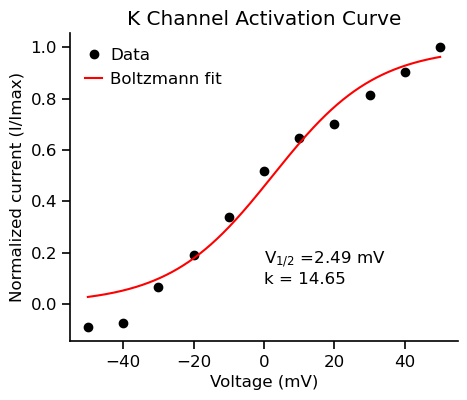

In [ ]:
I_norm = current_steps / np.max(current_steps)

# Fit the Boltzmann function (sigmoidal curve) to the data and overlay
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = 5 # Initial guess for the slope parameter to fit the curve
popt, _ = curve_fit(boltzmann, voltage_steps, I_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
I_fit = boltzmann(V_fit, V_half_fit, k_fit)
print(f"V_half = {V_half_fit:.2f} mV, k = {k_fit:.2f}")

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, I_norm, 'o', label='Data', color='black')
ax.plot(V_fit, I_fit, '-', label='Boltzmann fit', color='red')
ax.text(0.5, 0.3, 'V$_{1/2}$ ='+f'{V_half_fit:.2f} mV \nk = {k_fit:.2f}', transform=ax.transAxes, ha='left', va='top')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized current (I/Imax)')
ax.set_title('K Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()

### 2.4. Calculate the channel activation curve by calculating conductance

<img src="images/Na_IV_activation_analysis.png" width="800">


We will plot channel activation by calculating the conductance of the channel at different voltages and normalizing against the maximum conductance.

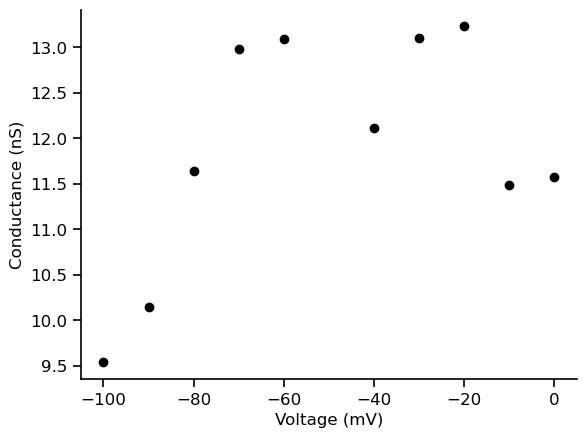

In [23]:
# Calculate the conductance at each point
G = current_steps / (voltage_steps - E_rev)

# We are estimating the G from single points, so errors will be larger close to the 
# reversal potential (where our calculation is very sensitive to small variations in V-E_rev).

# Remove the points within 5mv of the reversal potential
# (since the conductance is not well defined at the reversal potential)
delta_V = voltage_steps - E_rev
mask = np.abs(delta_V) > 5
voltage_steps = voltage_steps[mask]
current_steps = current_steps[mask]
G = G[mask]

# Plot the conductance
plt.plot(voltage_steps, G, 'o', color='black')
plt.xlabel('Voltage (mV)')
plt.ylabel('Conductance (nS)')
plt.show()

We will be fitting this function (Boltzmann equation) to your data points:
$$ \frac{I}{I_{\text{max}}} = I_{norm} = \frac{1}{1 + \exp\left(\frac{V_{\text{half}} - V}{k}\right)}$$

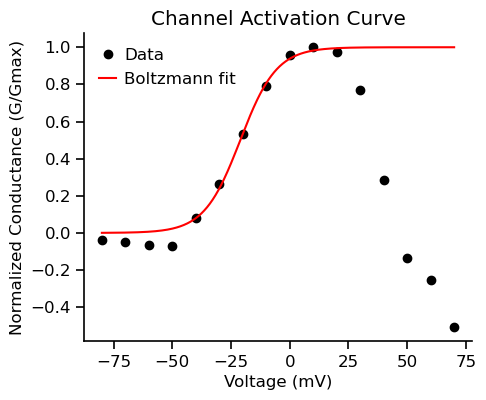

In [ ]:
# # Now we normalize these conductances by the maximum value, i.e. the fully open channel conductance
G_max = np.max(G) 

# # Sometime the Gmax measurement is a bit noisy, so can instead normalize against the average of the last 5 points
# G_max = np.mean(G[-5:]) 

# # Alternatively, we can use the line we fit above. 
# # If we fit the line correctly (around the E_rev), the slope of that line is the maximum conductance
# G_max = slope

# Now we normalize the conductances by the maximum value
G_norm = G / G_max


# --------------------------------------------------------------------------------------------------------------------
# Finally we can fit the Boltzmann function (sigmoidal curve) to the data 
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))

from scipy.optimize import curve_fit
k_guess = 5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, G_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
G_fit = boltzmann(V_fit, V_half_fit, k_fit)

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, G_norm, 'o', label='Data', color='black')
ax.plot(V_fit, G_fit, '-', label='Boltzmann fit', color='red')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized Conductance (G/Gmax)')
ax.set_title('Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()